In [464]:
import math
import numpy as np
import rasterio
import string 

from rasterio.plot import show
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from PIL import Image


In [465]:
cmap = "viridis"
pi=math.pi

In [466]:
with rasterio.open('./img/cropped/red.tif') as src:
    red=src.read(1)
with rasterio.open('./img/cropped/nir.tif') as src:
    nir = src.read(1)

with rasterio.open('./img/2. IMG_700101_000458_0092_NIR.TIF') as src:
    nir_field = src.read(1)

with rasterio.open('img/3. IMG_700101_000458_0092_RED.TIF') as src:
    red_field = src.read(1)

In [467]:
def calculate_ndvi(red, nir):
    ndvi = (nir - red) / (nir + red)
    return (ndvi)

In [468]:
def kurt_factor(ndvi):
    kurt_factor = np.mean((ndvi - np.mean(ndvi)) ** 4) / (np.var(ndvi) ** 2)
    return kurt_factor

In [469]:
red = red/65535.0
nir = nir/65535.0
red_field = red_field/65535.0
nir_field = nir_field/65535.0

ndvi =(nir.astype(float)-red.astype(float)/(nir+red))
ndvi_field =(nir_field.astype(float)-red_field.astype(float)/(nir_field+red_field))

In [470]:
# Calculate the NDVI values
ndvi = calculate_ndvi(red, nir)

3D Gaussian Graph

In [471]:
def create_one_graph(ndvi):
    # Define the parameters for the Gaussian bell function
    x = 0 # center point
    y = 0  # center point
    sigma_xy = 1  # spread in the xy plane
    sigma_z = 1  # spread in the z direction
    Qm =1  # maximum value of the bell function

    # Create a meshgrid for the x, y, and NDVI values
    xf, yf = np.meshgrid(np.linspace(-2, 2, ndvi.shape[1]), np.linspace(-2, 2, ndvi.shape[0]))
    ndvif = np.meshgrid(np.linspace(-1, 1, ndvi.shape[1]), np.linspace(-1, 1, ndvi.shape[0]))[0]

    # Create the 3D Gaussian bell function based on the NDVI values
    #Real function
    
    f = ((Qm * np.exp( -(ndvif - ndvi) ** 2 / (2 * sigma_z ** 2))) / (((2 * (np.pi ))** (3/2))* sigma_xy ** 2 * sigma_z)) * (np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) ))
    
    

    # Calculate the kurtosis, standard deviation, and amplitude of the plot
    kurtosis=kurt_factor(ndvi)
    std = np.std(f)
    amplitude = np.max(f)

    # Plot the 3D Gaussian bell function
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_array(f)
    cbar = plt.colorbar(mappable, ax=ax, pad=0.1)
    ax.plot_surface(xf, yf, f, cmap=cmap)
    textstr = '\n'.join((
        'k = {:.2f}'.format(kurtosis),
        'std. dev= {:.2f}'.format(std),
        'a= {:.2f}'.format(amplitude)))
    ax.text2D(0.05, 0.90, s=textstr, family='monospace', transform=ax.transAxes, ha='left', va='top', bbox=dict(facecolor='white', alpha=1, edgecolor='black', linewidth=0.2, boxstyle='square'))
    plt.rcParams['font.family'] = 'Times'
    
    plt.show()

Flat Normal Distribution Graph

In [472]:
def flatGraph(ndvi3):
    ndvi_flat3 = ndvi3.ravel()
    ndvi_flat3 = ndvi_flat3[~np.isnan(ndvi_flat3)]
    ndvi_flat3 = ndvi_flat3[np.isfinite(ndvi_flat3)]
    mean = np.mean(ndvi_flat3)
    std = np.std(ndvi_flat3)

    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(ndvi_flat3, bins=50, density=True, range=(-1, 1))
    y = norm.pdf(bins, mean, std)
    l = ax.plot(bins, y, 'r--', linewidth= 2)
    ax.set_xlabel('NDVI ')
    ax.set_ylabel('Frequency ')
    plt.legend(["NDVI Normal distribution", "Histogram of NDVI"], loc ="upper left")
    ax.set_title(r'Histogram of NDVI')
    textstr = '\n'.join((
        '$\mu={:.2f}$'.format(mean),
        '$\sigma={:.2f}$'.format(std)))
    ax.text(0.025, 0.80, s=textstr, transform=ax.transAxes, ha='left', va='top', bbox=dict(facecolor='white', alpha=1, edgecolor='black', linewidth=0.2, boxstyle='square'))
    plt.show()

Image cropper

In [473]:
def image_cropper_sin_ceros(left, top, right, bottom):
    x1 = left
    y1 = top
    x2 = right
    y2 = bottom
    red_cropped = red_field[y1:y2, x1:x2]
    nir_cropped =nir_field[y1:y2, x1:x2]
    ndvi = calculate_ndvi(red_cropped, nir_cropped)
    return ndvi

Creates a circle of -1 values in the center of the image

In [474]:
def make_center_circle(image, radius):
  """
  This function takes an image and makes the pixels in the center be -1.

  Args:
    image: An image.
    radius: The radius of the circle.

  Returns:
    A new image with the pixels in the center set to -1.
  """

  # Convert the image to a NumPy array.
  image_array = np.array(image)

  # Get the height and width of the image.
  height = image_array.shape[0]
  width = image_array.shape[1]

  # Find the center of the image.
  center_x = width // 2
  center_y = height // 2

  # Set the pixels in the circle to 0.
  for i in range(center_x - radius, center_x + radius + 1):
    for j in range(center_y - radius, center_y + radius + 1):
      distance = ((i - center_x) ** 2 + (j - center_y) ** 2) ** 0.5
      if distance <= radius:
        image_array[i][j] = -1

  # Convert the NumPy array back to an image.
  new_image = Image.fromarray(image_array)

  return image_array

Create circle around the image with negative values

In [475]:
def make_circle_inside(image, radius):
  """
  This function takes a 230 by 230 matrix and makes the pixels outside the circle be -1.

  Args:
    matrix: A 230 by 230 matrix.
    radius: The radius of the circle.

  Returns:
    A new matrix with the pixels outside the circle set to -1.
  """

   # Convert the image to a NumPy array.
  image_array = np.array(image)

  # Get the height and width of the image.
  height = image_array.shape[0]
  width = image_array.shape[1]

  # Find the center of the matrix.
  center_x = width // 2
  center_y = height // 2

  # Set the pixels outside the circle to 0.
  for i in range(height):
    for j in range(width):
      distance = ((i - center_x) ** 2 + (j - center_y) ** 2) ** 0.5
      if distance > radius:
        image_array[i][j] = -1

  return image_array


In [476]:
def multiple_2d_plot(ndvi_list):

    fig, ax = plt.subplots()

    for i in range(0, len(ndvi_list)):
        ndvi_flat = ndvi_list[i].ravel()
        ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]
        ndvi_flat = ndvi_flat[np.isfinite(ndvi_flat)]
        mean = np.mean(ndvi_flat)
        std = np.std(ndvi_flat)

        n, bins, patches = ax.hist(ndvi_flat, bins=50, density=True, range=(-1, 1), color='white')
        y = norm.pdf(bins, mean, std)
        l = ax.plot(bins, y, '--', linewidth=2, label=f"Specimen {string.ascii_uppercase[i]}", color=plt.cm.rainbow(i/len(ndvi_list)))

    ax.set_xlabel('NDVI')
    ax.set_ylabel('Frequency')
    plt.legend(loc="upper left")
    ax.set_title(r'Normal distribution of NDVI values by Image')

    plt.show()


SPECIMEN 0

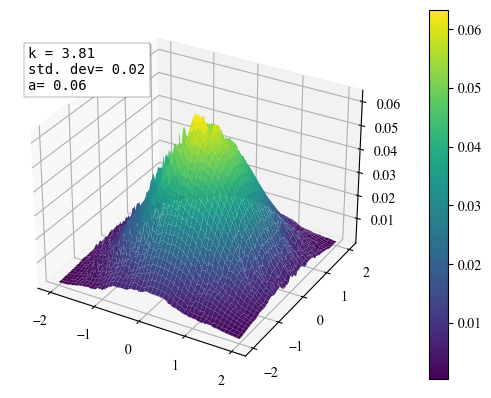

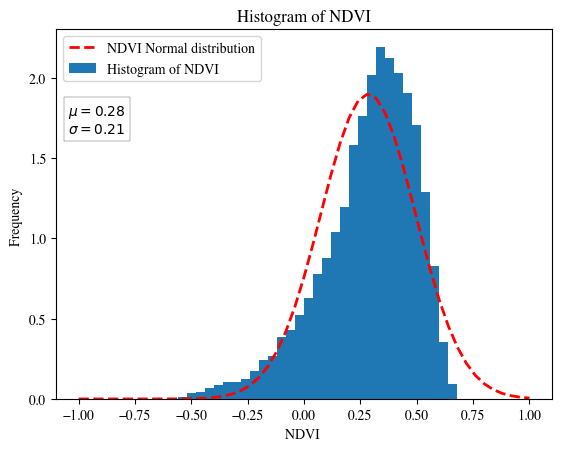

In [477]:
create_one_graph(ndvi)
flatGraph(ndvi)

SPECIMENS A TO C

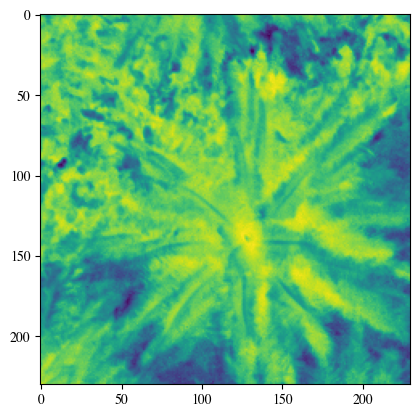

<Axes: >

In [478]:
ndvi1 = image_cropper_sin_ceros(420, 220, 650, 450)
ndvi2=image_cropper_sin_ceros(500, 420, 730, 650)
ndvi3=image_cropper_sin_ceros(520, 600, 750, 830)
show(ndvi1)


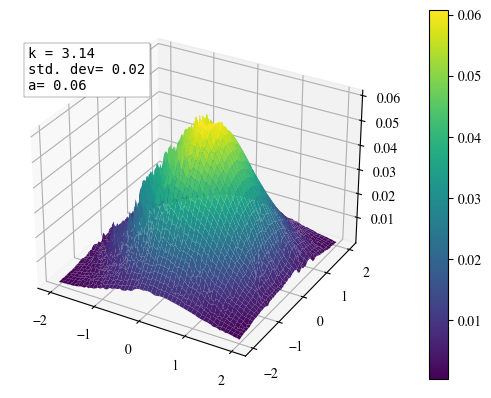

In [479]:
create_one_graph(ndvi1)



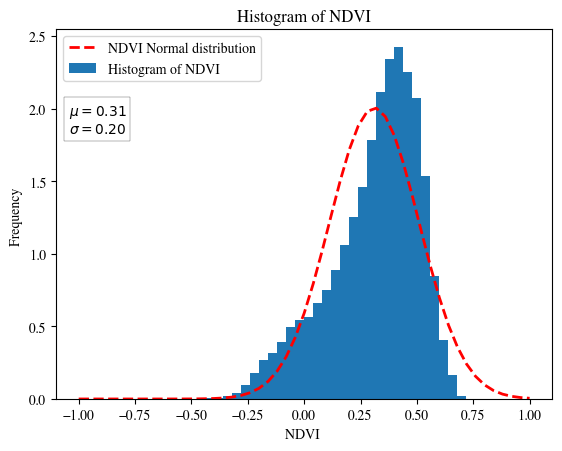

In [480]:
flatGraph(ndvi1)


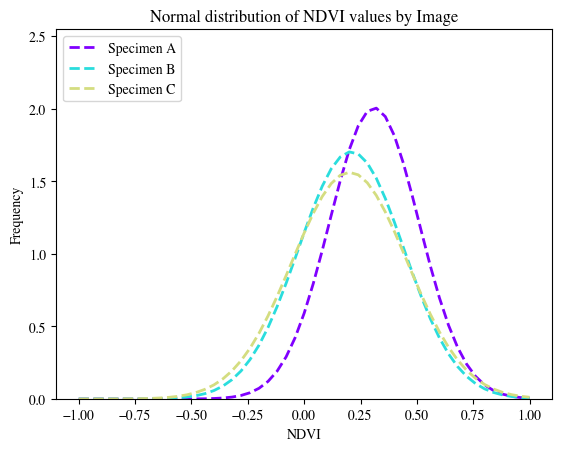

In [481]:
multiple_2d_plot([ndvi1, ndvi2, ndvi3])

DETECCIÓN DE ANOMALIAS

In [482]:
def make_center_circle(image, radius):
  """
  This function takes an image and makes the pixels in the center be 0.

  Args:
    image: An image.
    radius: The radius of the circle.

  Returns:
    A new image with the pixels in the center set to 0.
  """

  # Convert the image to a NumPy array.
  image_array = np.array(image)

  # Get the height and width of the image.
  height = image_array.shape[0]
  width = image_array.shape[1]

  # Find the center of the image.
  center_x = width // 2
  center_y = height // 2

  # Set the pixels in the circle to 0.
  for i in range(center_x - radius, center_x + radius + 1):
    for j in range(center_y - radius, center_y + radius + 1):
      distance = ((i - center_x) ** 2 + (j - center_y) ** 2) ** 0.5
      if distance <= radius:
        image_array[i][j] = -1

  # Convert the NumPy array back to an image.
  new_image = Image.fromarray(image_array)

  return image_array


In [483]:
def make_circle_inside(image, radius):
  """
  This function takes a 230 by 230 matrix and makes the pixels outside the circle be 0.

  Args:
    matrix: A 230 by 230 matrix.
    radius: The radius of the circle.

  Returns:
    A new matrix with the pixels outside the circle set to 0.
  """

   # Convert the image to a NumPy array.
  image_array = np.array(image)

  # Get the height and width of the image.
  height = image_array.shape[0]
  width = image_array.shape[1]

  # Find the center of the matrix.
  center_x = width // 2
  center_y = height // 2

  # Set the pixels outside the circle to 0.
  for i in range(height):
    for j in range(width):
      distance = ((i - center_x) ** 2 + (j - center_y) ** 2) ** 0.5
      if distance > radius:
        image_array[i][j] = -1

  return image_array


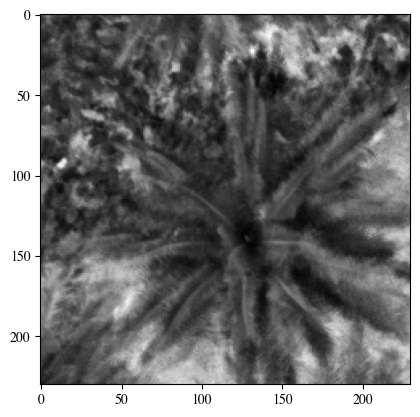

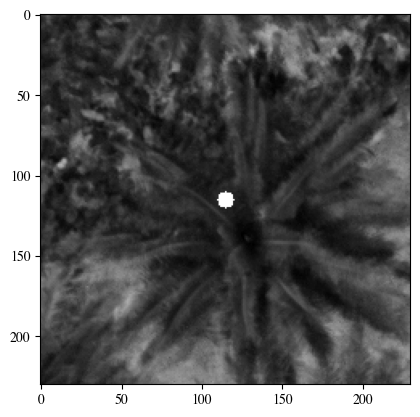

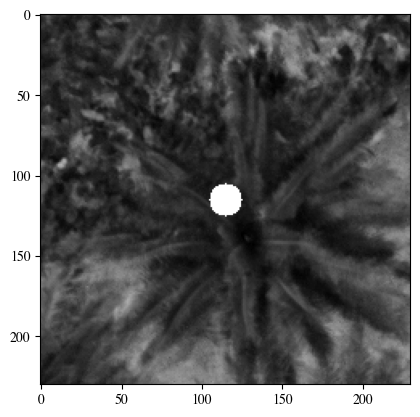

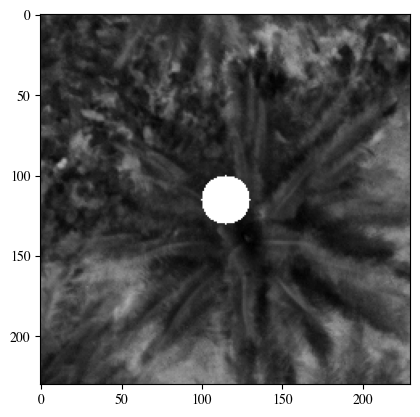

<Axes: >

In [484]:
ndvi_norm= ndvi1
show(ndvi_norm, cmap='binary')
sintetico1 = make_center_circle(ndvi_norm, 5)
sintetico2 = make_center_circle(ndvi_norm, 10)
sintetico3 = make_center_circle(ndvi_norm, 15)
sintetico4 = make_center_circle(ndvi_norm, 20)



show(sintetico1, cmap='binary')
show(sintetico2, cmap='binary')
show(sintetico3, cmap='binary')

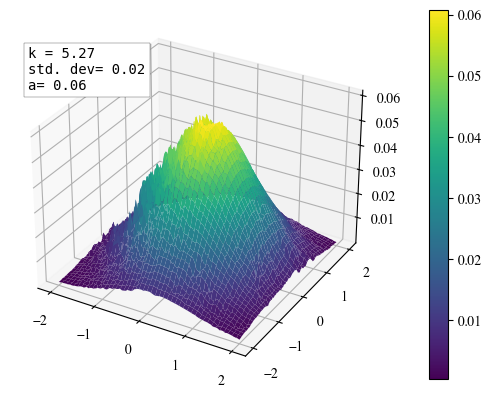

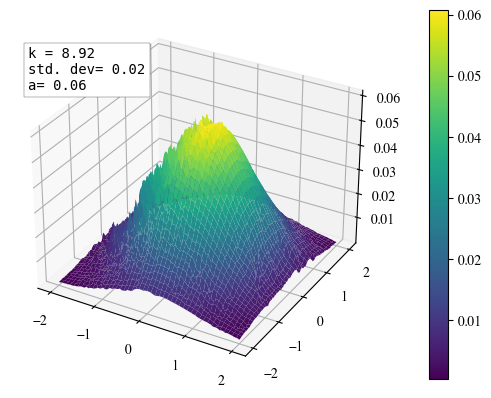

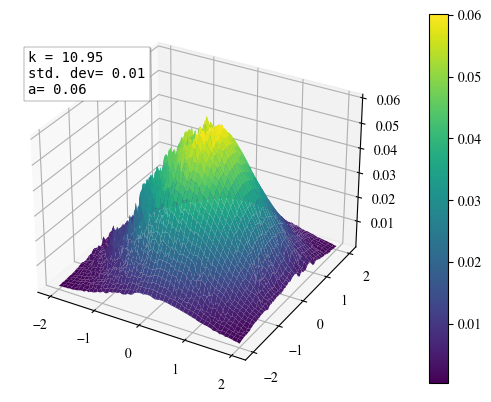

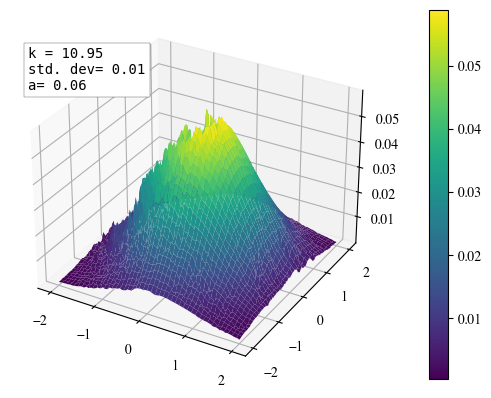

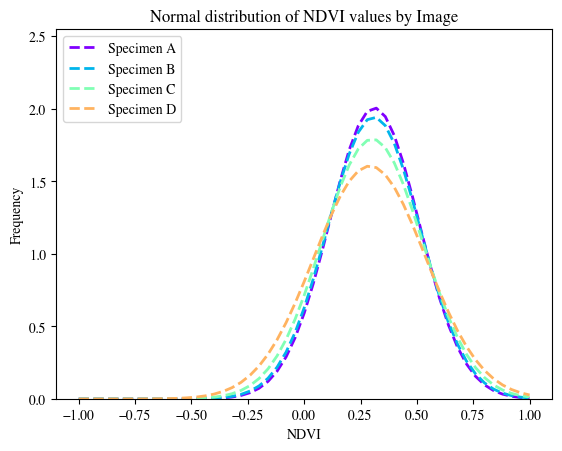

In [485]:
#create_one_graph(ndvi_norm)
create_one_graph(sintetico1)
create_one_graph(sintetico2)
create_one_graph(sintetico3)
create_one_graph(sintetico4)

multiple_2d_plot([ndvi_norm,sintetico1, sintetico2, sintetico3])